# Clusterization

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline

In [27]:
import pandas as pd
import numpy as np

## Learn about the data

In [28]:
# Load data
USArrests = pd.read_csv("Data/USArrests.csv", sep=",")
USArrests['StateAbbrv'] = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT","DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC","SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
USArrests.rename(columns={"Unnamed: 0": "State"}, inplace=True)
USArrests.head()

,State,Murder,Assault,UrbanPop,Rape,StateAbbrv
0,Alabama,13.2,236,58,21.2,AL
1,Alaska,10.0,263,48,44.5,AK
2,Arizona,8.1,294,80,31.0,AZ
3,Arkansas,8.8,190,50,19.5,AR
4,California,9.0,276,91,40.6,CA


The data have more dimensions than we can easily visualize, so we use PCA to reduce the number of dimensions.

As with clustering, it is necessary to scale the data before applying PCA.

You note that we scale the entire dataset, rather than adjusting the scale on the train and carrying over this scaling to future data (i.e. the test). Since we will not be using a test set here, it is therefore correct to use all of the scaled data.

In [29]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

df = USArrests[['Murder','Assault','UrbanPop','Rape']]
scaled_df = pd.DataFrame(preprocessing.scale(df), index=USArrests['State'], columns = df.columns)

fitted_pca = PCA().fit(scaled_df)
USArrests_pca = fitted_pca.transform(scaled_df)

The following `biplot function` plots the first two PCA components, and provides some helpful annotations

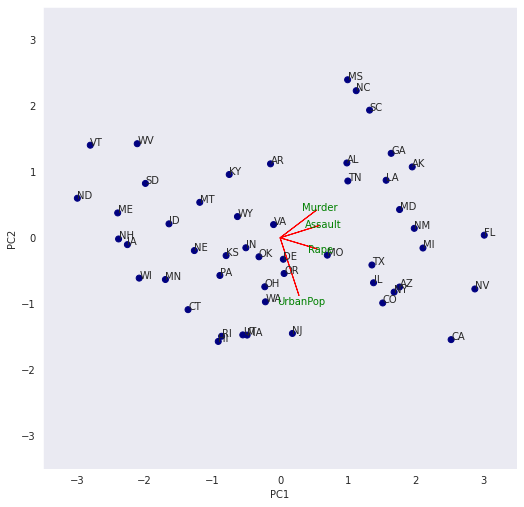

In [30]:
def biplot(pca_data, fitted_pca, original_dim_labels, point_labels, cluster=None):

    pca1_scores = pca_data[:,0]
    pca2_scores = pca_data[:,1]

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    newmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
            
    # plot each point in 2D post-PCA space
    if cluster is None:
        cluster = [0]*len(pca1_scores)
    else:
        step = cmap.N//max(cluster)
        cluster = [step*i for i in cluster]
    plt.scatter(pca1_scores, pca2_scores, c=cluster, cmap=newmap)

    # label each point
    for i in range(len(point_labels)):
        #print("pca1", pca1_scores[i])
        #print("pca2", pca2_scores[i])
        #print("label", point_labels[i])
        plt.text(pca1_scores[i],pca2_scores[i], point_labels[i])

    #for each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0,i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1,i]
        plt.arrow(0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2 ,color = 'r',alpha = 1)
        plt.text(raw_dims_delta_on_pca1*1.1, raw_dims_delta_on_pca2*1.1, original_dim_labels[i], color = 'g', ha = 'center', va = 'center')

plt.figure(figsize=(8.5,8.5))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(USArrests_pca, fitted_pca,
       original_dim_labels=scaled_df.columns,
       point_labels=USArrests['StateAbbrv'])

The red arrows and green text give us a sense of direction. If any state had 'murder' increase by one (scaled) unit, it would move in the direction of the 'murder' line by that amount.

An increase by one (scaled) unit of both 'murder' and 'Urban Pop' would apply both moves.

We can also make inferrences about what combination of crimes and population puts California at its observed point.

## Distances

One of the key ideas in clustering is the distance or disimilarity between points. Euclidean distance is common, though one is free to define domain-specific measures of how similar/distant two observations are.

* scipy `pdist` function computes the distances between all pairs of data points (which can be quite expensive for large data).
* scipy `squareform` turns the result into a numpy array (the raw format avoids storing redundant values)

In [31]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dist_eucl = pdist(scaled_df,metric="euclidean")
distances = pd.DataFrame(squareform(dist_eucl), index=USArrests["State"].values, columns=USArrests["State"].values)

We can then easily print the matrix of distances between states using seaborn

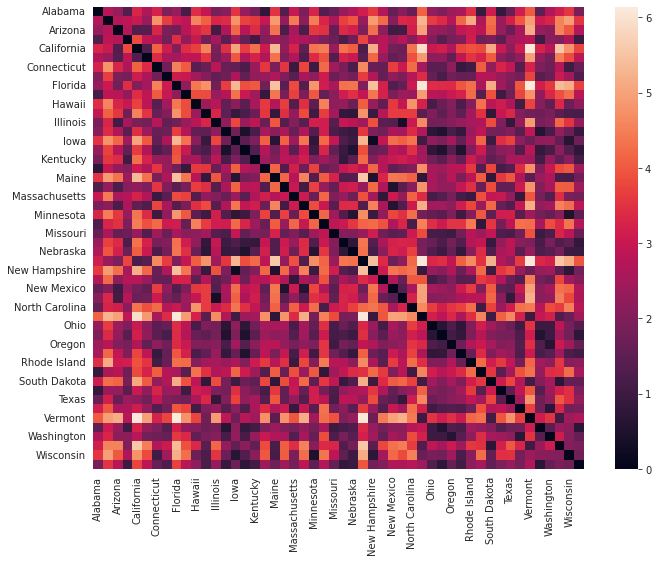

In [32]:
import seaborn as sns

plt.figure(figsize=(11,8.5))
sns.heatmap(distances)
plt.show()

## Clustering with K-means

Kmeans is a classical, workhorse clustering algorithm, and a common place to start. It assumes there are K centers and, starting from random guesses, algorithmically improves its guess about where the centers must be.

<div class="alert alert-block alert-danger">
Using the KMeans function of sklearn, propose a first clustering in 3 clusters with 25 runs

To help you, you must use the parameters:
    
* `n_clusters`: The number of clusters to form as well as the number of centroids to generate.
* `n_init`: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
* `random_state`: Determines random number generation for centroid initialization. Use an int to make the randomness deterministic.
    
Using the `cluster_centers` attribute, print the coodinate of each cluster centers.
</div>

In [33]:
from sklearn.cluster import KMeans

arrests_km = KMeans(n_clusters=3,n_init=25,random_state=123).fit(scaled_df)

arrests_km.cluster_centers_

array([[ 1.01513667,  1.02412028,  0.19959126,  0.85556386],
       [-0.88515915, -1.0213324 , -0.94990286, -0.92016524],
       [-0.49440658, -0.3864845 ,  0.58167593, -0.26431024]])

In [34]:
pd.DataFrame(arrests_km.cluster_centers_,columns=['Murder','Assault','UrbanPop','Rape'])

,Murder,Assault,UrbanPop,Rape
0,1.015137,1.024120,0.199591,0.855564
1,-0.885159,-1.021332,-0.949903,-0.920165
2,-0.494407,-0.386484,0.581676,-0.264310


The `labels_` attribute tell us which cluster each point was assigned to

In [35]:
# Copy the original dataset
df_cluster = scaled_df.copy()
# Add label to the dataset
df_cluster['Cluster'] = arrests_km.labels_
# Print part of the dataset
df_cluster['Cluster'].head()

State
Alabama       0
Alaska        0
Arizona       0
Arkansas      1
California    0
Name: Cluster, dtype: int32

We now calculate the average of the points of each cluster to obtain the centroid found by K-means.

In [36]:
df_centroids = df_cluster.groupby('Cluster').mean()
df_centroids.head()

,Murder,Assault,UrbanPop,Rape
Cluster,,,,
0,1.015137,1.024120,0.199591,0.855564
1,-0.885159,-1.021332,-0.949903,-0.920165
2,-0.494407,-0.386484,0.581676,-0.264310


<div class="alert alert-block alert-danger">
Do we get the same value as when looking at the cluster_centers_ attribute ?
</div>

In [37]:
arrests_km.cluster_centers_

array([[ 1.01513667,  1.02412028,  0.19959126,  0.85556386],
       [-0.88515915, -1.0213324 , -0.94990286, -0.92016524],
       [-0.49440658, -0.3864845 ,  0.58167593, -0.26431024]])

Plot the dataset with the cluster attributes

/home/icarrara/miniconda3/envs/Env_Igor/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


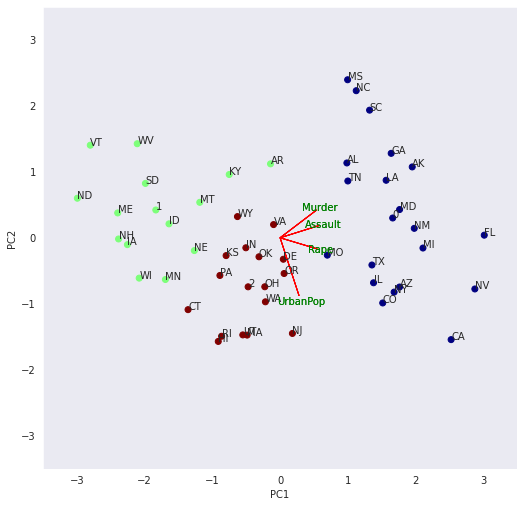

In [38]:
plt.figure(figsize=(8.5,8.5))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(USArrests_pca, fitted_pca,
       original_dim_labels=scaled_df.columns,
       point_labels=USArrests['StateAbbrv'],
       cluster=arrests_km.labels_)

Centroids_pca = fitted_pca.transform(arrests_km.cluster_centers_)

biplot(Centroids_pca, fitted_pca,
       original_dim_labels=scaled_df.columns,
       point_labels=np.unique(arrests_km.labels_),
       cluster=np.unique(arrests_km.labels_))

### Plot the distortions of K-means

<div class="alert alert-block alert-danger">
You can easily run K-Means with several run for a range of clusters using a for loop and collecting the distortions into a list.
    
You can collect the distortions using the `inertia_`attribute. `inertia_`is the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
    
Then plots the distortions of K-means.
</div>

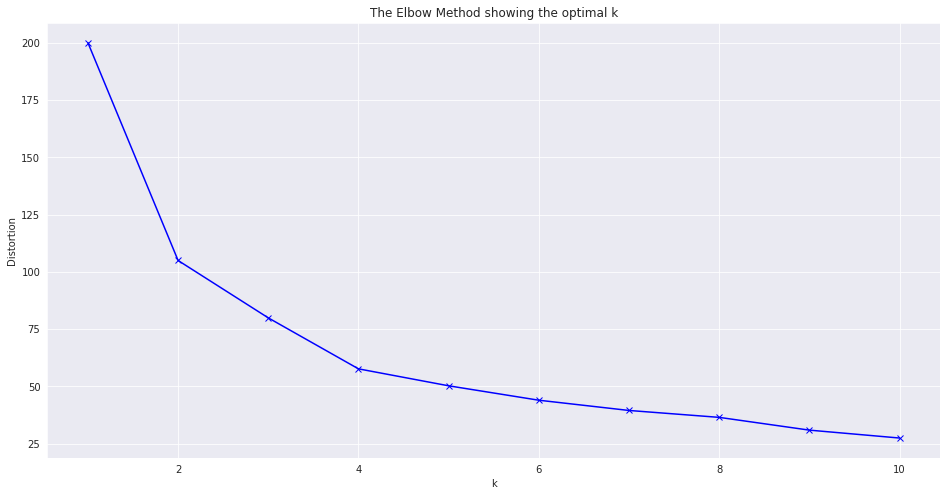

In [39]:
distortions = []
for k in range(1,11):
    km = KMeans(n_clusters=k, init='random', n_init=25, random_state=123).fit(scaled_df)
    distortions.append(km.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(range(1,11), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<div class="alert alert-block alert-danger">
What is the best number of clusters when using the Elbow method?
</div>

### Silhouette Plots
Silhouette plots give rich information on the quality of a clustering


In [40]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    # axes will be first 2 PCA components
    pca = PCA(n_components=2).fit(X)
    X_pca = pca.transform(X)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X_pca[:, 0]
    ys = X_pca[:, 1]


    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters (transform to PCA space for plotting)
    centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 3, the average silhouette_score is 0.30813622648945616.


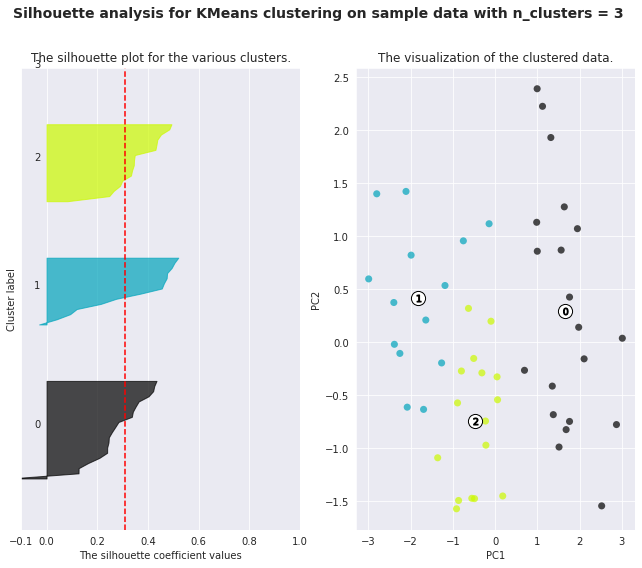

In [41]:
fitted_km = KMeans(n_clusters=3,n_init=25,random_state=123).fit(scaled_df)
cluster_labels = fitted_km.labels_

silplot(scaled_df.values, cluster_labels, fitted_km)

In [42]:
# Objects with negative silhouette
sil = silhouette_samples(scaled_df, fitted_km.labels_)

USArrests.loc[sil<=0,:]

,State,Murder,Assault,UrbanPop,Rape,StateAbbrv
3,Arkansas,8.8,190,50,19.5,AR
24,Missouri,9.0,178,70,28.2,MO


### Silhouette Score

<div class="alert alert-block alert-danger">
Now plot the score of the silhouette as the number of clusters varies.
</div>

Optimized at 2 clusters


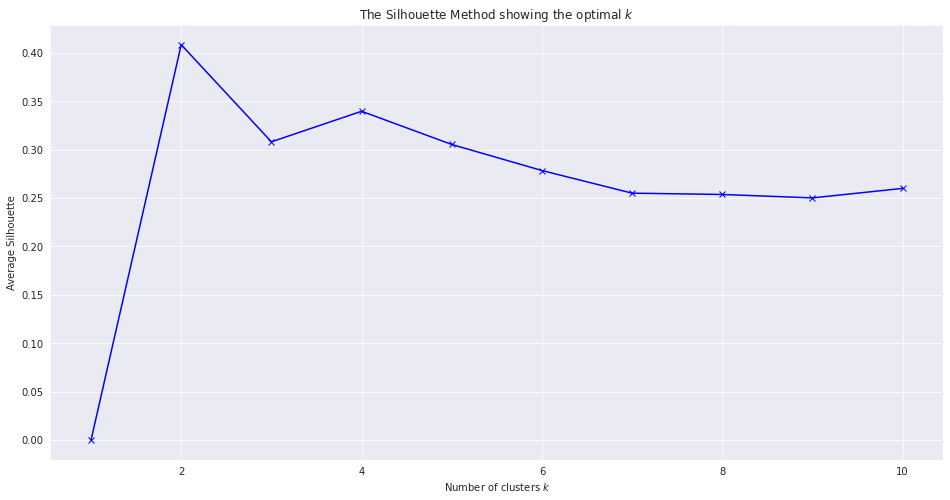

In [43]:
from sklearn.metrics import silhouette_score

scores = [0]  # silhouette score for 1 cluster
for i in range(2,11):
    km = KMeans(n_clusters=i, init='random', n_init=25, random_state=109).fit(scaled_df)
    scores.append(silhouette_score(scaled_df, km.labels_))

print("Optimized at", max(range(len(scores)), key=scores.__getitem__)+1, "clusters")

plt.figure(figsize=(16,8))
plt.plot(range(1,11), scores, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Silhouette Method showing the optimal $k$')
plt.show()

<div class="alert alert-block alert-danger">
What is the best number of clusters when using the Silhouet method?

Is it the same as with the Elbow method?
    
Cluster the dataset with the best number of clusters and try to explain each cluster.
</div>

/home/icarrara/miniconda3/envs/Env_Igor/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


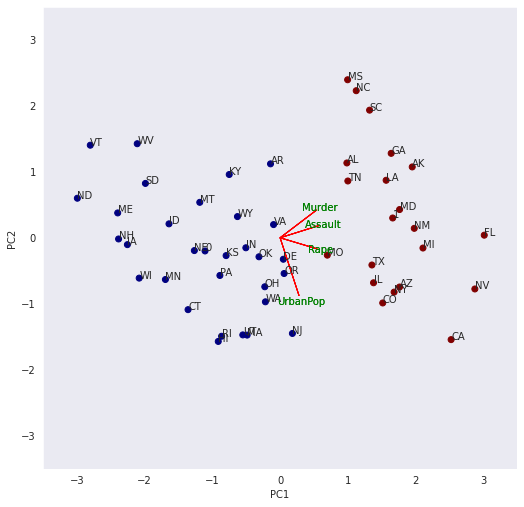

In [44]:
''' TO DO '''
arrests_km = KMeans(n_clusters=2,n_init=25,random_state=123).fit(scaled_df)

plt.figure(figsize=(8.5,8.5))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(USArrests_pca, fitted_pca,
       original_dim_labels=scaled_df.columns,
       point_labels=USArrests['StateAbbrv'],
       cluster=arrests_km.labels_)

Centroids_pca = fitted_pca.transform(arrests_km.cluster_centers_)
biplot(Centroids_pca, fitted_pca,
       original_dim_labels=scaled_df.columns,
       point_labels=np.unique(arrests_km.labels_),
       cluster=np.unique(arrests_km.labels_))

#### Gap Statistic

The gap statistic is a method for estimating the number of clusters in a dataset. The techniques uses the output of any clustering algorithm, comparing the change in within-cluster dispersion withthat expected under an appropriate reference null distribution. The original paper is [here](https://web.stanford.edu/~hastie/Papers/gap.pdf).

* Githup page: [https://github.com/milesgranger/gap_statistic]
* [K-Means Clustering and the Gap-Statistics](https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29)

In [45]:
# need to install library 'gap-stat'
!pip install gap-stat

In [46]:
from gap_statistic import OptimalK

gs_obj = OptimalK()

n_clusters = gs_obj(scaled_df.values,                    # The dataset
                    n_refs=100,                           # Number of runs
                    cluster_array=np.arange(1, 15))      # Range of clusterization
print('Optimal clusters: ', n_clusters)

Optimal clusters:  5


In [47]:
gs_obj.gap_df.head()

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,1.0,0.233948,16.459023,0.065239,53.248851,56.012525,-0.278833,55.101395
1,2.0,0.595167,15.673911,0.082386,86.009464,87.862007,0.077094,87.671249
2,3.0,0.606883,13.592098,0.088810,70.094204,71.755989,0.208046,71.530575
3,4.0,0.483797,10.884374,0.084959,49.443116,50.879487,-0.189459,50.723811
4,5.0,0.772702,10.875047,0.099447,60.092413,61.373109,0.188133,61.302930


The columns of the dataframe are:

* n_clusters - The number of clusters for which the statistics in this row were calculated.
* gap_value - The Gap value for this n.
* gap* - The Gap* value for this n.
* ref_dispersion_std - The standard deviation of the reference distributions for this n.
* sk - The standard error of the Gap statistic for this n.
* sk* - The standard error of the Gap* statistic for this n.
* diff - The diff value for this n (see the methodology section for details).
* diff* - The diff* value for this n (corresponding to the diff value for Gap*).

Additionally, the relation between the above measures and the number of clusters can be plotted by calling the OptimalK.plot_results() method (meant to be used inside a Jupyter Notebook or a similar IPython-based notebook), which prints four plots:

* A plot of the Gap value versus n, the number of clusters.
* A plot of diff versus n.
* A plot of the Gap* value versus n, the number of clusters.
* A plot of the diff* value versus n.

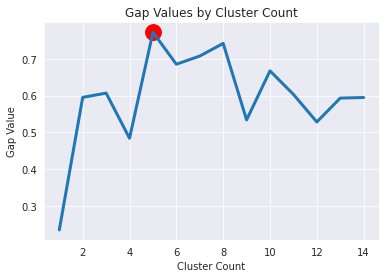

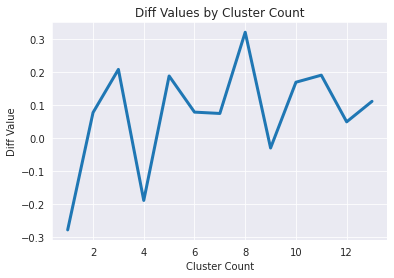

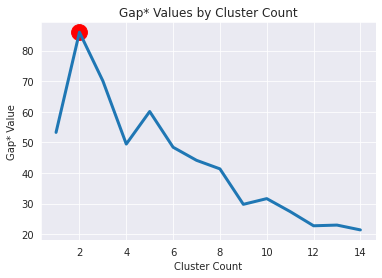

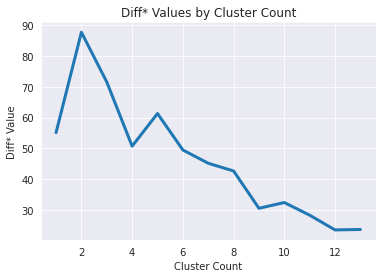

In [48]:
gs_obj.plot_results()

<div class="alert alert-block alert-danger">    
Cluster the dataset with the best number of clusters givent by gap-stat and try to explain each cluster.
</div>

/home/icarrara/miniconda3/envs/Env_Igor/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


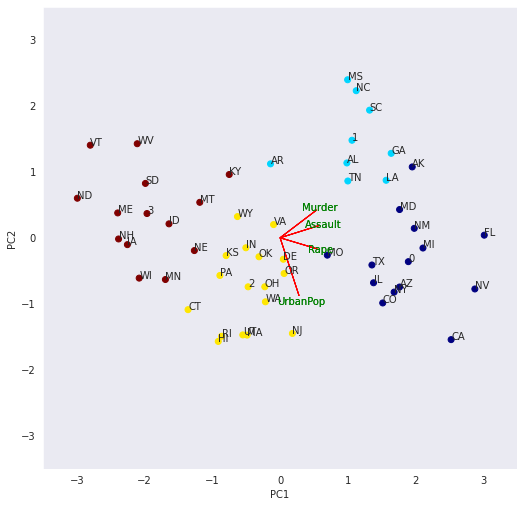

In [49]:
''' TO DO '''
arrests_km = KMeans(n_clusters=4,n_init=25,random_state=123).fit(scaled_df)

plt.figure(figsize=(8.5,8.5))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(USArrests_pca, fitted_pca,
       original_dim_labels=scaled_df.columns,
       point_labels=USArrests['StateAbbrv'],
       cluster=arrests_km.labels_)

Centroids_pca = fitted_pca.transform(arrests_km.cluster_centers_)
biplot(Centroids_pca, fitted_pca,
       original_dim_labels=scaled_df.columns,
       point_labels=np.unique(arrests_km.labels_),
       cluster=np.unique(arrests_km.labels_))

<div class="alert alert-block alert-danger">    
Try to explain each cluster
</div>

## Hierarchical clustering

K-means is a very 'hard' clustering: points belong to exactly one cluster, no matter what. A hierarchical clustering creates a nesting of clusters as existing clusters are merged or split.

Dendograms (literally: branch graphs) can show the pattern of splits/merges. Unfortunately dendograms are not implemented in sklearn. We have to use the scipy library.

In [50]:
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

The following code shows different dendograms build with different algorithms:

1. Min (or single linkage) algorithm with euclidian distance: the distance of the new cluster, is the min.
1. Max (or complete linkage) algorithm with euclidian distance: : the distance of the new cluster, is the max.
1. Ward algorithm with euclidean distance: the distance of the new cluster, is the average of the sum of the square of the distance.

![three linkage type](https://www.researchgate.net/profile/Pamela-Guevara/publication/281014334/figure/fig57/AS:418517879934980@1476793847581/The-three-linkage-types-of-hierarchical-clustering-single-link-complete-link-and.png)

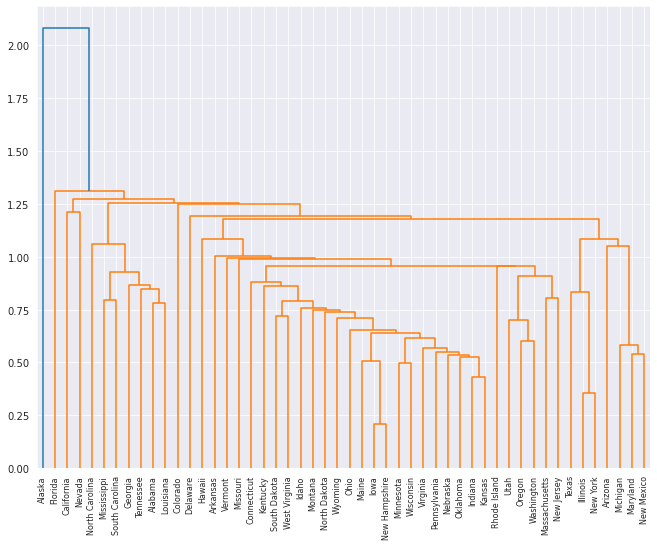

In [51]:
# Min (or single linkage) algorithm with euclidian distance
plt.figure(figsize=(11,8.5))
dist_mat = pdist(scaled_df, metric="minkowski", p=2) # Euclidian
ward_data = hac.single(dist_mat) # min

hac.dendrogram(ward_data, labels=USArrests["State"].values);
plt.show()

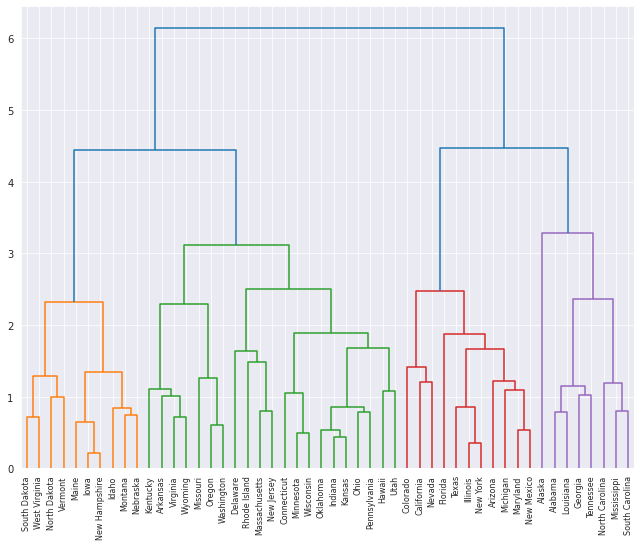

In [52]:
# Max (or complete linkage) algorithm with euclidian distance
plt.figure(figsize=(11,8.5))
dist_mat = pdist(scaled_df, metric="minkowski", p=2) # Euclidian
ward_data = hac.complete(dist_mat) # max

hac.dendrogram(ward_data, labels=USArrests["State"].values);
plt.show()

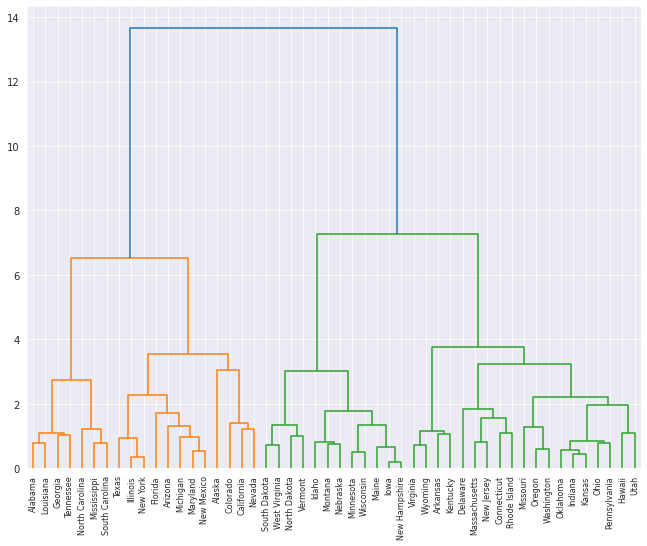

In [53]:
# Ward algorithm with euclidean distance
plt.figure(figsize=(11,8.5))
dist_mat = pdist(scaled_df, metric="minkowski", p=2) # Euclidian
ward_data = hac.ward(dist_mat) # average

hac.dendrogram(ward_data, labels=USArrests["State"].values);
plt.show()

If sklearn can't draw dendogrames directly. It is nevertheless possible :

* to do agglomerative clustering with sklearn ([sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html))
* to draw dendograms with sklearn ([doc](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py))

In the following example, we search for 3 clusters using a Euclidean distance and ward as a linkage criterion.

/home/icarrara/miniconda3/envs/Env_Igor/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


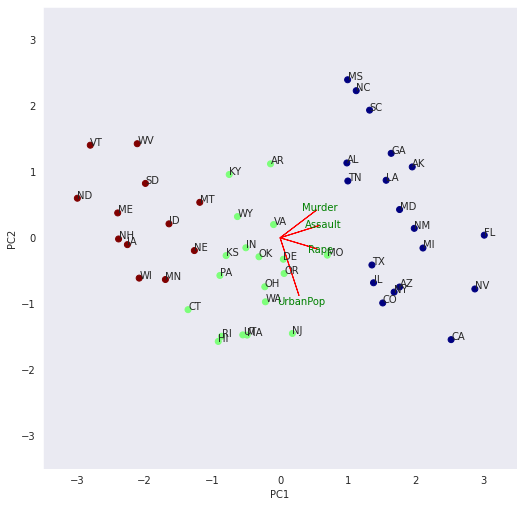

In [54]:
from sklearn.cluster import AgglomerativeClustering

arrests_ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
arrests_ac.fit_predict(scaled_df)

plt.figure(figsize=(8.5,8.5))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(USArrests_pca, fitted_pca,
       original_dim_labels=scaled_df.columns,
       point_labels=USArrests['StateAbbrv'],
       cluster=arrests_ac.labels_)

LA SUITE N'EST PAS AU POINT

<div class="alert alert-block alert-danger">    
By reading the documentation, can you divide the dendogram at a distance of 4. We will use a Euclidean distance and max as linking criteria.

* How many clusters are obtained?
* What is the composition of each cluster?
</div>

In [55]:
from sklearn.cluster import AgglomerativeClustering

arrests_ac = AgglomerativeClustering(compute_distances=True, compute_full_tree=True, affinity='euclidean', linkage='complete')  
arrests_ac.fit_predict(scaled_df)

/home/icarrara/miniconda3/envs/Env_Igor/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1])

In [56]:
arrests_ac.children_

array([[14, 28],
       [12, 31],
       [13, 15],
       [22, 48],
       [35, 52],
       [19, 30],
       [36, 46],
       [18, 50],
       [45, 49],
       [40, 47],
       [25, 26],
       [ 0, 17],
       [34, 37],
       [23, 39],
       [20, 29],
       [11, 60],
       [54, 62],
       [42, 51],
       [33, 44],
       [ 3, 58],
       [ 9, 41],
       [ 6, 53],
       [10, 43],
       [21, 55],
       [16, 69],
       [61, 70],
       [32, 63],
       [ 4, 27],
       [ 2, 73],
       [24, 56],
       [59, 68],
       [57, 65],
       [ 5, 77],
       [38, 64],
       [ 7, 83],
       [67, 78],
       [66, 72],
       [ 8, 85],
       [71, 86],
       [74, 79],
       [80, 81],
       [75, 76],
       [82, 87],
       [84, 88],
       [89, 93],
       [ 1, 91],
       [90, 94],
       [92, 95],
       [96, 97]])

Numbre of cluster: 2


TypeError: zip() takes no keyword arguments

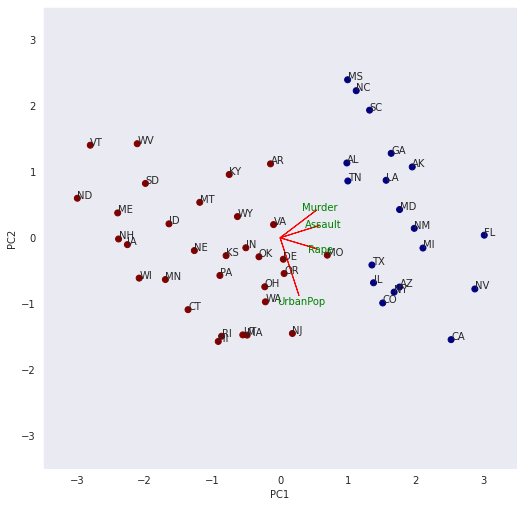

In [57]:
plt.figure(figsize=(8.5,8.5))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(USArrests_pca, fitted_pca,
       original_dim_labels=scaled_df.columns,
       point_labels=USArrests['StateAbbrv'],
       cluster=arrests_ac.labels_)

print("Numbre of cluster:", arrests_ac.n_clusters)
for i in range(arrests_ac.n_clusters):
    cluster = [s for s, c in zip(USArrests['StateAbbrv'], cluster=arrests_ac.labels_) if c==i]
    print("Cluster", i, ":", cluster)